<a href="https://colab.research.google.com/github/dariashcherbakovaaa/MA_DSE_Unimi/blob/network_science/SNA_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Settings

In [1]:
from google.colab import userdata
import os
os.environ['KAGGLE_USERNAME'] = userdata.get("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = userdata.get("KAGGLE_KEY")
!kaggle datasets download -d thedevastator/relato-business-network-graph-373663-domain-conn
!unzip relato-business-network-graph-373663-domain-conn.zip -d data

relato-business-network-graph-373663-domain-conn.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  relato-business-network-graph-373663-domain-conn.zip
replace data/companies.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace data/companies.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace data/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace data/links.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import log
from collections import Counter, defaultdict
import scipy.stats
from scipy.stats import poisson, powerlaw

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, precision_recall_curve, auc, classification_report

import networkx as nx

# Read data & preprocess

In [3]:
links = pd.read_csv('/content/data/links.csv')

<ipython-input-3-d97df1c187af>:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  links = pd.read_csv('/content/data/links.csv')


In [4]:
links = links[['home_name', 'link_name', 'type']]
links.shape

(373663, 3)

In [5]:
links = links.dropna()
links.shape

(373311, 3)

In [6]:
links = links.drop_duplicates()
links.shape

(373239, 3)

In [7]:
links['type'].value_counts()

partnership    112675
customer        80452
supplier        79389
investment      71630
competitor      29093
Name: type, dtype: int64

In [8]:
competitors = links[links['type'] == 'competitor']
competitors.shape

(29093, 3)

In [9]:
customers = links[links['type'] == 'customer']
customers.shape

(80452, 3)

In [10]:
collabs = links[links['type'] == 'partnership']
collabs.shape

(112675, 3)

# Competitor data

In [11]:
competitors['home_name'].nunique()

7129

In [12]:
competitors['link_name'].nunique()

6474

In [13]:
competitors['home_name'].value_counts()[:10]

Microsoft          246
IBM                225
Google             222
Facebook           216
SAP                163
Apple Inc.         145
Oracle             142
Amazon             123
Hewlett-Packard    110
Cisco              108
Name: home_name, dtype: int64

In [14]:
competitors['home_name'].value_counts()[::-1][:10]

Helium          1
Corbis          1
GreenPoint      1
FleetMatics     1
CBR             1
Greggs          1
Greif           1
Cordis          1
Fleetwood RV    1
Oxmoor House    1
Name: home_name, dtype: int64

In [15]:
competitors['link_name'].value_counts()[:10]

Google             319
Apple Inc.         232
Microsoft          211
Facebook           205
Amazon             202
Sony               130
IBM                124
Walmart            122
Samsung            111
Hewlett-Packard     97
Name: link_name, dtype: int64

In [16]:
competitors['link_name'].value_counts()[::-1][:10]

Nagios                   1
Ambac Financial Group    1
Winston & Strawn         1
KNIME                    1
Kemin Industries         1
Targus                   1
Kroll                    1
Phillips Petroleum       1
Thermador                1
Armada                   1
Name: link_name, dtype: int64

# Competitors (whole network)

In [17]:
G = nx.Graph()
G =nx.from_pandas_edgelist(competitors, 'home_name', 'link_name')
print(G)

Graph with 8596 nodes and 23654 edges


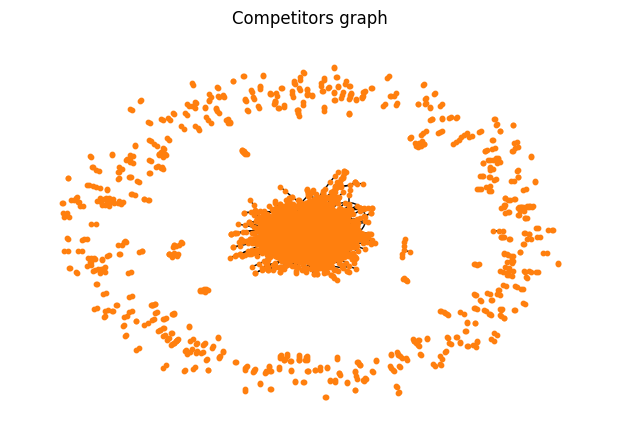

In [18]:
plt.figure(figsize=(6, 4))

nx.draw(G, with_labels=False, node_size=10, node_color="tab:orange", pos=nx.spring_layout(G))
plt.title("Competitors graph")
plt.show()

In [19]:
counts_home = competitors.groupby('home_name').size()
counts_link = competitors.groupby('link_name').size()

selected_companies_home = counts_home[counts_home >= 10].index
selected_companies_link = counts_link[counts_link >= 10].index

sample_company = competitors[
    competitors['home_name'].isin(selected_companies_home) & competitors['link_name'].isin(selected_companies_link)
    ]
print(sample_company['home_name'].value_counts())

Google                        126
Microsoft                     121
Facebook                      109
IBM                           103
SAP                            81
                             ... 
Sitecore                        1
Fusion                          1
Horlicks                        1
Rally Software Development      1
SpringCM's                      1
Name: home_name, Length: 546, dtype: int64


In [20]:
G = nx.Graph()
G =nx.from_pandas_edgelist(sample_company, 'home_name', 'link_name')
print(G)

Graph with 859 nodes and 5807 edges


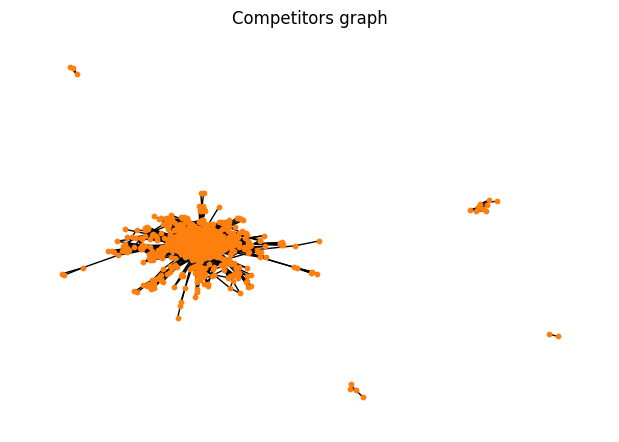

In [21]:
plt.figure(figsize=(6, 4))

nx.draw(G, with_labels=False, node_size=10, node_color="tab:orange", pos=nx.spring_layout(G))
plt.title("Competitors graph")
plt.show()

## Network EDA

In [22]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
density = nx.density(G)
print(f"\nThe density of the network: {density:.4f}")

Number of nodes: 859
Number of edges: 5807

The density of the network: 0.0158


In [23]:
degrees = list(dict(G.degree()).values())

avg_degree = np.mean(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)
std_dev_degree = np.std(degrees)
median_degree = np.median(degrees)

print('Avg.degree:', avg_degree, "\n\nMin degree:", min_degree,
      "\n\nMax degree:", max_degree, "\n\nStandard Deviation:", std_dev_degree,
      "\n\nMedian:", median_degree)

Avg.degree: 13.520372526193247 

Min degree: 1 

Max degree: 203 

Standard Deviation: 17.959351123020667 

Median: 9.0


In [24]:
num_connected_components = nx.number_connected_components(G)
print(f'Number of connetced components in the network: {num_connected_components}')

Number of connetced components in the network: 5


In [25]:
rn = nx.fast_gnp_random_graph(G.order(),density)

random_nodes = rn.order()
random_edges = rn.size()
print("Random nodes:", random_nodes,"\nRandom edges:", random_edges)

num_connected_components = nx.number_connected_components(rn)
print(f'Number of connetced components in the network: {num_connected_components}')

degrees = list(dict(rn.degree()).values())

avg_degree = np.mean(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)
std_dev_degree = np.std(degrees)
median_degree = np.median(degrees)

print('Avg.degree:', avg_degree, "\n\nMin degree:", min_degree,
      "\n\nMax degree:", max_degree, "\n\nStandard Deviation:", std_dev_degree,
      "\n\nMedian:", median_degree)

Random nodes: 859 
Random edges: 5774
Number of connetced components in the network: 1
Avg.degree: 13.443538998835855 

Min degree: 4 

Max degree: 31 

Standard Deviation: 3.6365771561488205 

Median: 13.0


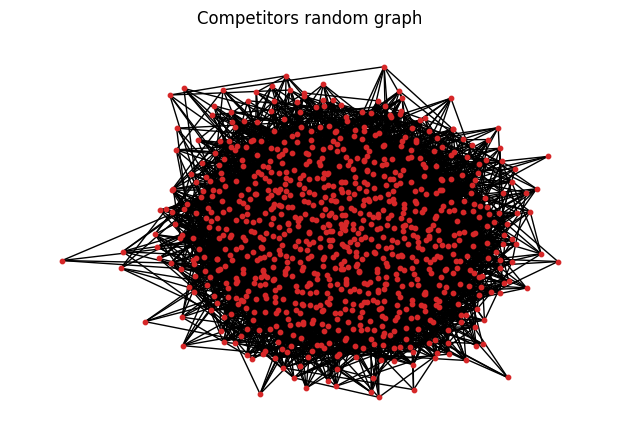

In [26]:
plt.figure(figsize=(6, 4))

nx.draw(rn, with_labels=False, node_size=10, node_color="tab:red", pos=nx.spring_layout(rn))
plt.title("Competitors random graph")
plt.show()

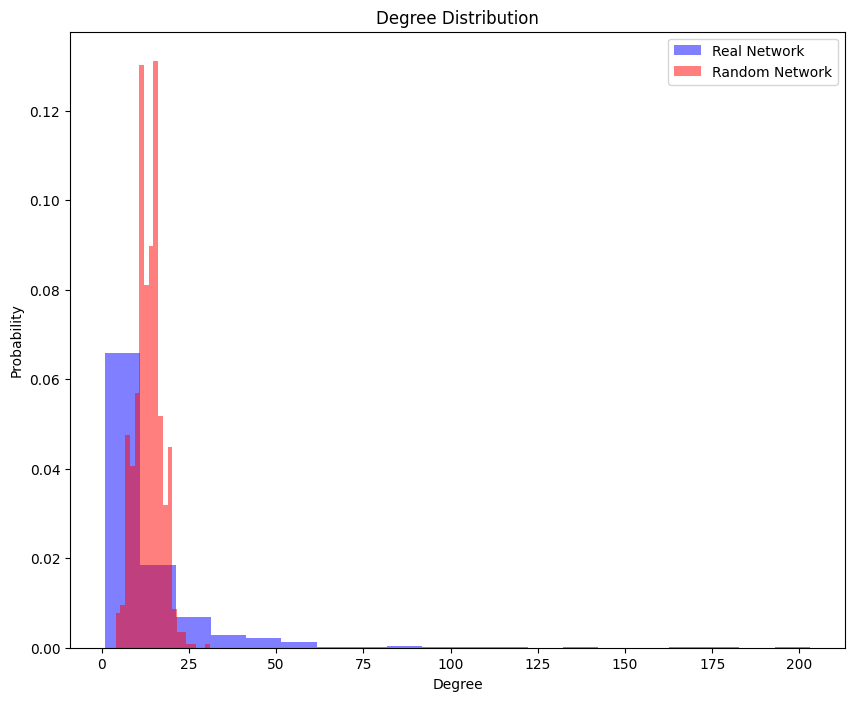

In [27]:
degree_sequence_G = [d for n, d in G.degree()]
degree_sequence_rn = [d for n, d in rn.degree()]

plt.figure(figsize=(10, 8))
plt.hist(degree_sequence_G, bins=20, alpha=0.5, color='b', density=True, label='Real Network')
plt.hist(degree_sequence_rn, bins=20, alpha=0.5, color='r', density=True, label='Random Network')

plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Degree Distribution')
plt.legend(loc='upper right')
plt.show()

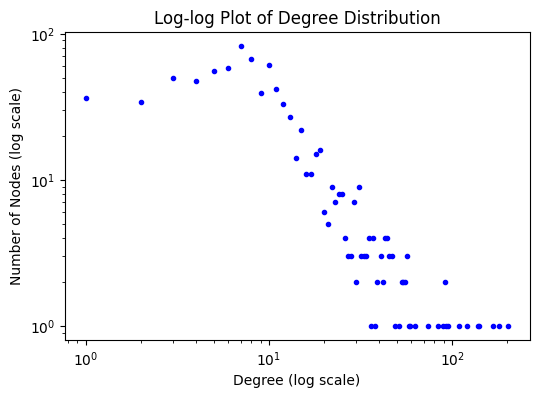

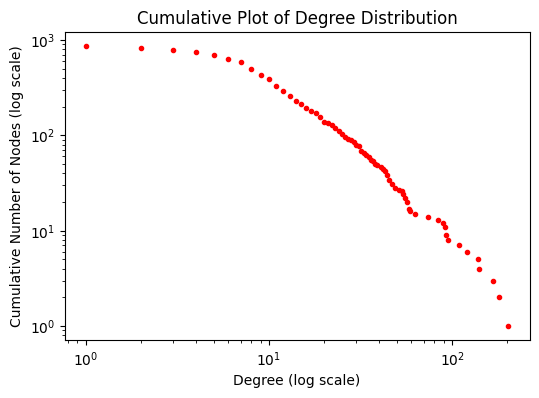

In [28]:
degree_counts_G = Counter(degree_sequence_G)

sorted_degrees = sorted(degree_counts_G.keys())
cumulative_counts = [sum(degree_counts_G[d] for d in sorted_degrees if d >= degree) for degree in sorted_degrees]

# log-log plot
plt.figure(figsize=(6, 4))
plt.loglog(sorted_degrees, [degree_counts_G[d] for d in sorted_degrees], 'bo', markersize=3)
plt.xlabel('Degree (log scale)')
plt.ylabel('Number of Nodes (log scale)')
plt.title('Log-log Plot of Degree Distribution')
plt.grid(True, which="both", ls='')
plt.show()

# cumulative plot
plt.figure(figsize=(6, 4))
plt.loglog(sorted_degrees, cumulative_counts, 'ro', markersize=3)
plt.xlabel('Degree (log scale)')
plt.ylabel('Cumulative Number of Nodes (log scale)')
plt.title('Cumulative Plot of Degree Distribution')
plt.grid(True, which="both", ls="")
plt.show()

In [29]:
# degree centrailty
degree_centrality = nx.degree_centrality(G)
degree_central = max(degree_centrality,key=degree_centrality.get)

# closeness centrailty
closeness_centrality = nx.closeness_centrality(G)
close_central = max(closeness_centrality,key=closeness_centrality.get)

# betweenness centrality
betw_centrality = nx.betweenness_centrality(G)
betw_central = max(betw_centrality,key=betw_centrality.get)

# eigenvector centrality
eigen_centrality = nx.eigenvector_centrality(G)
eigen_central = max(eigen_centrality,key=eigen_centrality.get)

print("Most central nodes according to the following definitions:",
      "\t\n\nDegree:", degree_central,
      "\t\n\nCloseness", close_central,
      "\t\n\nBetweenness", betw_central,
      "\t\n\nEigenvector", eigen_central)

Most central nodes according to the following definitions: 	

Degree: Google 	

Closeness Google 	

Betweenness Google 	

Eigenvector Google


In [30]:
sort_degree_centrality = dict(sorted(degree_centrality.items(),key=lambda item:item[1],reverse=True))
top_degree = list(sort_degree_centrality.keys())[:5]

sort_close_centrality = dict(sorted(closeness_centrality.items(),key=lambda item:item[1],reverse=True))
top_close = list(sort_close_centrality.keys())[:5]

sort_betw_centrality = dict(sorted(betw_centrality.items(),key=lambda item:item[1],reverse=True))
top_betw = list(sort_betw_centrality.keys())[:5]

sort_eigen_centrality = dict(sorted(eigen_centrality.items(),key=lambda item:item[1],reverse=True))
top_eigen = list(sort_eigen_centrality.keys())[:5]

print(
    "Top 10 nodes according to:\t\nDegree centrality:", top_degree,"\nCloseness:", top_close, "\nBetweness:", top_betw,
    "\nEigenvector:", top_eigen
)

Top 10 nodes according to:	
Degree centrality: ['Google', 'Microsoft', 'Facebook', 'Apple Inc.', 'IBM'] 
Closeness: ['Google', 'Microsoft', 'Facebook', 'Apple Inc.', 'IBM'] 
Betweness: ['Google', 'Microsoft', 'Facebook', 'Apple Inc.', 'IBM'] 
Eigenvector: ['Google', 'Microsoft', 'Facebook', 'Apple Inc.', 'IBM']


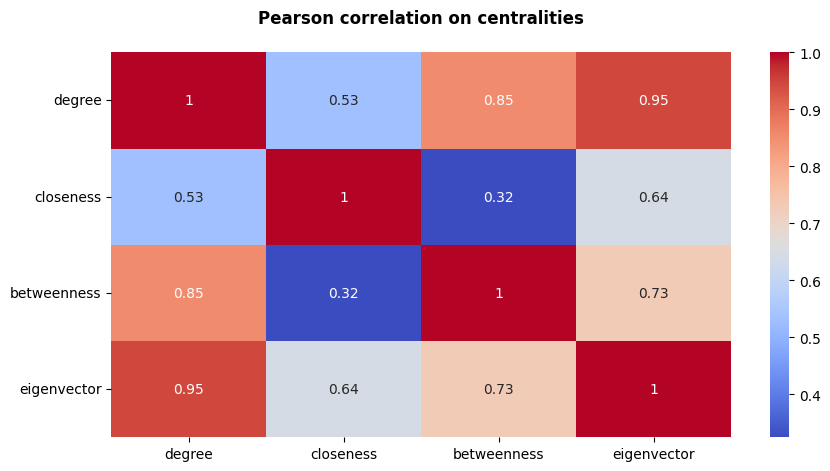

In [31]:
all_centr = [degree_centrality,closeness_centrality,betw_centrality,eigen_centrality]
corrs = [[scipy.stats.pearsonr(list(c1.values()), list(c2.values()))[0] for c1 in all_centr] for c2 in all_centr]
centralities = ['degree', 'closeness','betweenness','eigenvector']
plt.figure(figsize = (10,5))
sns.heatmap(pd.DataFrame(corrs),annot = True,cmap = 'coolwarm')
plt.xticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.yticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.title('Pearson correlation on centralities\n', weight = 'bold')
plt.show()

In [32]:
if nx.is_connected(G) == True:
  print('The graph is connected')
else:
  print('The graph is not connected')
num_connected_components = nx.number_connected_components(G)
print(f'Number of connetced components in the network: {num_connected_components}')

The graph is not connected
Number of connetced components in the network: 5


In [33]:
# largest connected component
len_components = [len(c) for c in nx.connected_components(G)]
components = [c for c in nx.connected_components(G)]

lcc = G.subgraph(components[0])
print(lcc.number_of_nodes())
print(lcc.number_of_edges())

avg_shrt_path_len_lcc = nx.average_shortest_path_length(lcc)
print(avg_shrt_path_len_lcc)

diam_lcc = nx.diameter(lcc)
print(diam_lcc)

840
5783
3.140938759293944
9


In [34]:
components_count = defaultdict(int)

for comp in len_components:
  components_count[comp] +=1

components_count

defaultdict(int, {840: 1, 4: 1, 10: 1, 2: 1, 3: 1})

In [35]:
# bridges
print(nx.has_bridges(G))
bridges = len(list(nx.bridges(G,root=None)))
print(bridges)
perc_bridge = bridges/G.number_of_edges()
print(perc_bridge)

True
38
0.006543826416394007


In [36]:
def count_local_and_global_bridges(G):
    local_bridges = 0
    global_bridges = 0

    for edge in G.edges():
        temp_G = G.copy()
        temp_G.remove_edge(*edge)


        if nx.is_connected(temp_G):

            u, v = edge
            if not nx.has_path(temp_G, u, v):
                local_bridges += 1
        else:
            global_bridges += 1

    return local_bridges, global_bridges

local_bridges, global_bridges = count_local_and_global_bridges(G)
print("Local Bridges:", local_bridges)
print("Global Bridges:", global_bridges)

Local Bridges: 0
Global Bridges: 5807


In [37]:
# assortativity
assortativity = nx.degree_assortativity_coefficient(G)
print(assortativity)

-0.027732774679885587


In [38]:
gcc = nx.transitivity(G)
avg_lcc = nx.average_clustering(G)

print("Global clustering coefficient:", gcc,"\nAverage local clustering coefficient:", avg_lcc)

Global clustering coefficient: 0.1545333181844004 
Average local clustering coefficient: 0.313865408122082


In [39]:
# community detection greedy

from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import modularity

greedy_communities = list(greedy_modularity_communities(G))
greedy_modularity_value = modularity(G, greedy_communities)
print(f"Network Modularity (Greedy algorithm): {greedy_modularity_value:.3f}")
greedy_num_partitions = len(greedy_communities)
greedy_partition_sizes = [len(community) for community in greedy_communities]
greedy_partition_sizes.sort(reverse=True)

print(f"Number of partitions (communities) obtained by Greedy algorithm: {greedy_num_partitions}")
print(f"Size of each partition: {greedy_partition_sizes}")

Network Modularity (Greedy algorithm): 0.367
Number of partitions (communities) obtained by Greedy algorithm: 20
Size of each partition: [260, 239, 69, 58, 47, 28, 26, 25, 18, 18, 17, 13, 10, 10, 6, 4, 4, 3, 2, 2]


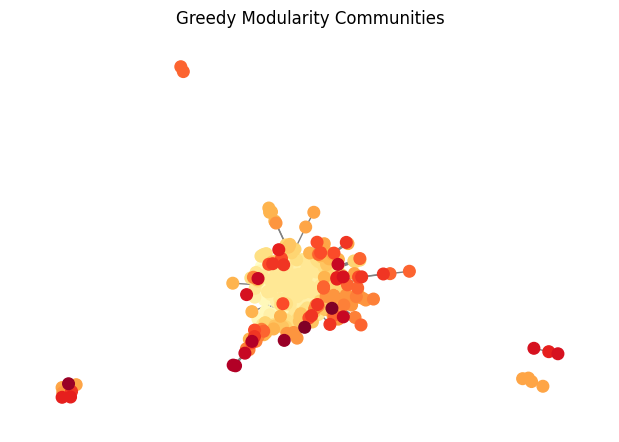

In [40]:
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42)
colors = [i for i, community in enumerate(greedy_communities) for _ in community]
nx.draw(G, pos, with_labels=False, node_size=70, cmap=plt.cm.YlOrRd, node_color=colors, edge_color='gray')
plt.title('Greedy Modularity Communities')
plt.show()

In [41]:
# Louvain algorithm

import community.community_louvain
partition = community.community_louvain.best_partition(G)

modularity_value = community.community_louvain.modularity(partition, G)
print(f"Network Modularity: {modularity_value:.3f}")
num_partitions = max(partition.values()) + 1
print(f"Number of communities obtained by Louvain algorithm: {num_partitions}")

Network Modularity: 0.386
Number of communities obtained by Louvain algorithm: 23


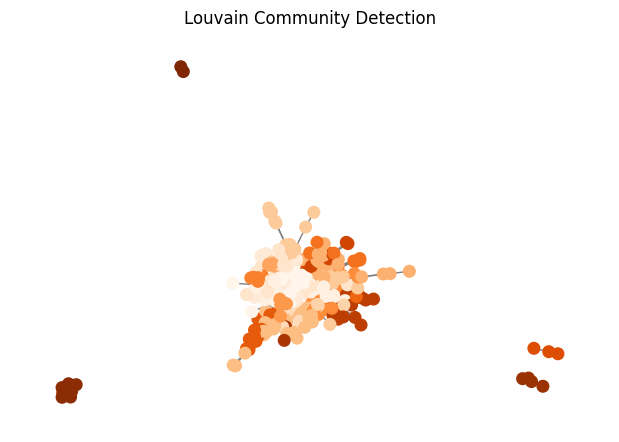

In [42]:
plt.figure(figsize=(6,4))
pos = nx.spring_layout(G, seed = 42)
node_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_size=70, node_color=node_colors, cmap=plt.cm.Oranges, edge_color='gray')
plt.title('Louvain Community Detection')
plt.show()

## ML part

Link prediction

In [43]:
positive_datapoints = list(G.edges())
positive_datapoints = [(u,v) for u,v in positive_datapoints]
len(positive_datapoints)

5807

In [44]:
negative_datapoints = []
nodes_set = list(G.nodes())
count = 0
while count < len(positive_datapoints):
    u, v = np.random.choice(nodes_set, size=2, replace=True)
    if (not G.has_edge(u, v) and not G.has_edge(v, u)):
        negative_datapoints.append((u, v))
        count += 1

In [45]:
dataset_link_prediction =  pd.DataFrame()
datapoints =  positive_datapoints + negative_datapoints
datapoints[:10]

[('Samsung', 'Garmin'),
 ('Samsung', 'A10 Networks'),
 ('Samsung', 'Apple Inc.'),
 ('Samsung', 'Google'),
 ('Samsung', 'Intel'),
 ('Samsung', 'Dell'),
 ('Samsung', 'Qualcomm'),
 ('Samsung', 'Hewlett-Packard'),
 ('Samsung', 'Southwest Airlines'),
 ('Samsung', 'Bloomberg')]

In [46]:
dataset_link_prediction['jaccard'] = [j for _,_, j in nx.jaccard_coefficient(G, datapoints)]
dataset_link_prediction['rai'] = [j for _,_, j in nx.resource_allocation_index(G, datapoints)]
dataset_link_prediction['aai'] = [sum(1 / log(G.degree(w)) for w in nx.common_neighbors(G, u, v) if G.degree(w) != 0 and G.degree(w) != 0) if any(G.degree(w) != 0 for w in nx.common_neighbors(G, u, v)) else 0 for u, v in datapoints]
dataset_link_prediction['pref'] = [j for _,_, j in nx.preferential_attachment(G, datapoints)]
dataset_link_prediction['label'] = [1 for _ in range(len(positive_datapoints))] + [0 for _ in range(len(negative_datapoints))]
dataset_link_prediction['home'] = [u for u, _ in datapoints]
dataset_link_prediction['customer'] = [v for _, v in datapoints]
dataset_link_prediction.sample(8)

,jaccard,rai,aai,pref,label,home,customer
1691,0.090909,0.220201,1.109048,203,1,Alcatel-Lucent,Ciena Corporation
3035,0.078431,0.183835,1.239630,666,1,Chevrolet,Pontiac
3789,0.108108,0.126489,1.886336,1425,1,Ferrari,NPR
3645,0.062500,0.023229,0.441668,288,1,Akamai,Costco
8443,0.000000,0.000000,0.000000,3,0,Horlicks,VWO
8201,0.000000,0.000000,0.000000,18,0,Yammer,Joss & Main
230,0.095238,0.470878,3.460932,3161,1,Hewlett-Packard,EMC
4929,0.000000,0.000000,0.000000,160,1,BlackRock,PeopleFinders


In [47]:
X = dataset_link_prediction[['jaccard', 'rai', 'aai', 'pref', 'home', 'customer']]
y = dataset_link_prediction['label']

In [48]:
X.shape, y.shape

((11614, 6), (11614,))

In [49]:
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_.shape, y_train.shape

((8710, 6), (8710,))

In [50]:
X_train = X_train_.drop(columns = ['home', 'customer'])
X_test = X_test_.drop(columns = ['home', 'customer'])

X_train.shape, X_test.shape

((8710, 4), (2904, 4))

In [51]:
column_preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), ['jaccard', 'rai', 'aai', 'pref'])],
    remainder='passthrough'
)

link_predictor = Pipeline([
    ('preprocessing', column_preprocessor),
    ('classifier', LogisticRegression(penalty=None))])

link_predictor.fit(X_train, y_train)
accuracy = link_predictor.score(X_test, y_test)
print(f"Accuracy on the testing set: {accuracy:.2%}")

Accuracy on the testing set: 79.99%


In [52]:
y_predicted = link_predictor.predict(X_test)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81      1410
           1       0.88      0.70      0.78      1494

    accuracy                           0.80      2904
   macro avg       0.81      0.80      0.80      2904
weighted avg       0.81      0.80      0.80      2904



*- of all objects that the model predicted as class 0, 76% actually belong to class 0, and 89% of all class 0 objects were correctly predicted by the model.*

*- of all objects that the model predicted as class 1, 91% actually belong to class 1, and 72% of all class 1 objects were correctly predicted by the model`*

In [53]:
link_predictor['classifier'].coef_

array([[11.72773861, 26.62178449, -8.77113534, 89.67883462]])

In [54]:
coefficients = link_predictor['classifier'].coef_

probabilities = X_test_[['jaccard', 'rai', 'aai', 'pref']].dot(coefficients.T.reshape(-1, 1))

threshold = 0.5
connected_indices = probabilities > threshold
connected_indices = connected_indices.values
connected_pairs = X_test_.loc[connected_indices[:, 0], ['home', 'customer']]
connected_pairs = connected_pairs.drop_duplicates()
print(connected_pairs.head(10))

              home                customer
6315     PagerDuty  Saudi Basic Industries
7811          VUDU                  Macy's
8015        Reebok             AstraZeneca
3660           SAP       Johnson & Johnson
1971      T-Mobile                   Icahn
7103        Cerner                 Safeway
1766         Volvo                  Amtrak
7413        Fusion             Joss & Main
6422  ARM Holdings                   Bosch
9232         Auth0                     BMW


In [55]:
print(connected_pairs.sample(10))

                                home         customer
9468                  Array Networks            Roche
2199                          Amazon  Western Digital
8452                       Accenture              JBL
7669   World Wrestling Entertainment         GoToMyPC
866                             Jeep              ATG
5662                      Streamline             Gild
9224                            Opel      Warner Bros
6904                           Skype    TD Ameritrade
8063                           ruxit           Intuit
10003                            ITV            Zerto


Clustering

In [56]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Assuming X contains your numerical features
X = dataset_link_prediction[['jaccard', 'rai', 'aai', 'pref']]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

# Print cluster labels
print(clusters)


[0 0 2 ... 0 0 0]


In [57]:
num_clusters = len(np.unique(clusters))
print("# clusters:", num_clusters)

# clusters: 4


In [58]:
num_outliers = np.sum(clusters == -1)
print("# noise:", num_outliers)

# noise: 148


In [59]:
for cluster_id in np.unique(clusters):
    if cluster_id == -1:
        continue
    cluster_points = X[clusters == cluster_id]
    cluster_mean = np.mean(cluster_points, axis=0)
    print(f"Avg for cluster {cluster_id}: {cluster_mean}")

Avg for cluster 0: jaccard      0.059151
rai          0.101591
aai          0.774096
pref       631.130032
dtype: float64
Avg for cluster 1: jaccard        0.165263
rai            1.205363
aai            9.911896
pref       11111.300000
dtype: float64
Avg for cluster 2: jaccard        0.216496
rai            1.460194
aai           11.876045
pref       12983.000000
dtype: float64


In [60]:
present_link = list(G.edges())
present_link = [(u, v) for u, v in present_link]

absent_link = []
nodes_set = list(G.nodes())
k = 0
while k < len(present_link):
  u , v = np.random.choice(nodes_set, size = 2, replace = True)
  if (not G.has_edge(u, v) and not G.has_edge(v , u)):
    absent_link.append((u,v))
    k +=1

dataset = pd.DataFrame()
all_links = present_link + absent_link

dataset['company'] = [u for u, _ in all_links]
dataset['competitor'] = [v for _, v in all_links]
dataset['label'] = [1 for _ in range(len(present_link))] + [0 for _ in range(len(absent_link))]

dataset

,company,competitor,label
0,Samsung,Garmin,1
1,Samsung,A10 Networks,1
2,Samsung,Apple Inc.,1
3,Samsung,Google,1
4,Samsung,Intel,1
...,...,...,...
11609,ExxonMobil,ThreatTrack Security,0
11610,Quality Technology Services,Target Corporation,0
11611,Pixar,BigMachines,0
11612,Quality Technology Services,Pegasystems,0


# Customer data

In [61]:
G = nx.Graph()
G = nx.from_pandas_edgelist(customers, 'home_name', 'link_name')
print(G)

Graph with 19653 nodes and 77601 edges


In [62]:
customer_count = customers.groupby('home_name').size()
selected_home_companies = customer_count[customer_count >= 9].index & customer_count[customer_count <= 15].index
sampled_customer = customers[customers['home_name'].isin(selected_home_companies)]

sampled_customer

<ipython-input-62-ad6a91b52f61>:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  selected_home_companies = customer_count[customer_count >= 9].index & customer_count[customer_count <= 15].index


,home_name,link_name,type
23426,Big Data & Analytics For Financial Services,Process Excellence Network,customer
23427,Big Data & Analytics For Financial Services,Amazon Web Services,customer
23428,Big Data & Analytics For Financial Services,Intel,customer
23429,Big Data & Analytics For Financial Services,Splunk,customer
23430,Big Data & Analytics For Financial Services,Smarsh,customer
...,...,...,...
360388,Publicus Groupe,Bristol-Myers Squibb,customer
360389,Publicus Groupe,Carrefour,customer
360390,Publicus Groupe,Citigroup,customer
360391,Publicus Groupe,The Coca-Cola Company,customer


In [63]:
G = nx.Graph()
G =nx.from_pandas_edgelist(sampled_customer, 'home_name', 'link_name')
print(G)

Graph with 3762 nodes and 7600 edges


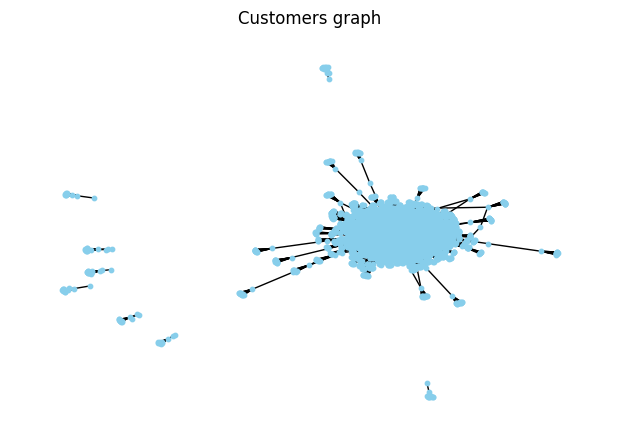

In [64]:
plt.figure(figsize=(6, 4))

nx.draw(G, with_labels=False, node_size=10, node_color="skyblue", pos=nx.spring_layout(G))
plt.title("Customers graph")
plt.show()

### EDA

In [65]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
density = nx.density(G)
print(f"\nThe density of the network: {density:.4f}")

Number of nodes: 3762
Number of edges: 7600

The density of the network: 0.0011


In [66]:
degrees = list(dict(G.degree()).values())

avg_degree = np.mean(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)
std_dev_degree = np.std(degrees)
median_degree = np.median(degrees)

print('Avg.degree:', avg_degree, "\n\nMin degree:", min_degree,
      "\n\nMax degree:", max_degree, "\n\nStandard Deviation:", std_dev_degree,
      "\n\nMedian:", median_degree)

Avg.degree: 4.040404040404041 

Min degree: 1 

Max degree: 113 

Standard Deviation: 6.215555989093085 

Median: 1.0


In [67]:
rn = nx.fast_gnp_random_graph(G.order(),density)

random_nodes = rn.order()
random_edges = rn.size()
print("Random nodes:", random_nodes,"\nRandom edges:", random_edges)

num_connected_components = nx.number_connected_components(rn)
print(f'Number of connetced components in the network: {num_connected_components}')

degrees = list(dict(rn.degree()).values())

avg_degree = np.mean(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)
std_dev_degree = np.std(degrees)
median_degree = np.median(degrees)

print('Avg.degree:', avg_degree, "\n\nMin degree:", min_degree,
      "\n\nMax degree:", max_degree, "\n\nStandard Deviation:", std_dev_degree,
      "\n\nMedian:", median_degree)

Random nodes: 3762 
Random edges: 7518
Number of connetced components in the network: 59
Avg.degree: 3.996810207336523 

Min degree: 0 

Max degree: 13 

Standard Deviation: 1.9964057098288208 

Median: 4.0


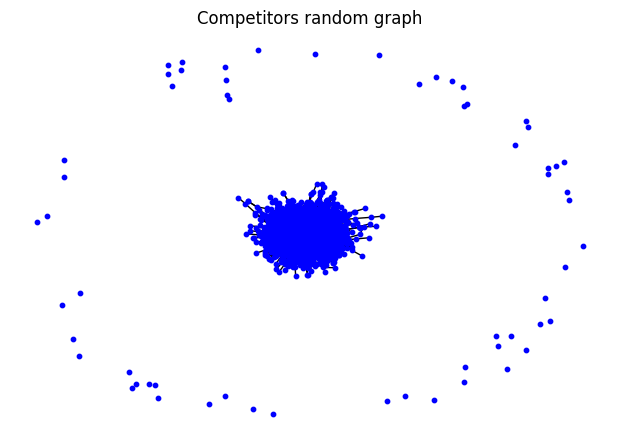

In [68]:
plt.figure(figsize=(6, 4))

nx.draw(rn, with_labels=False, node_size=10, node_color="blue", pos=nx.spring_layout(rn))
plt.title("Competitors random graph")
plt.show()

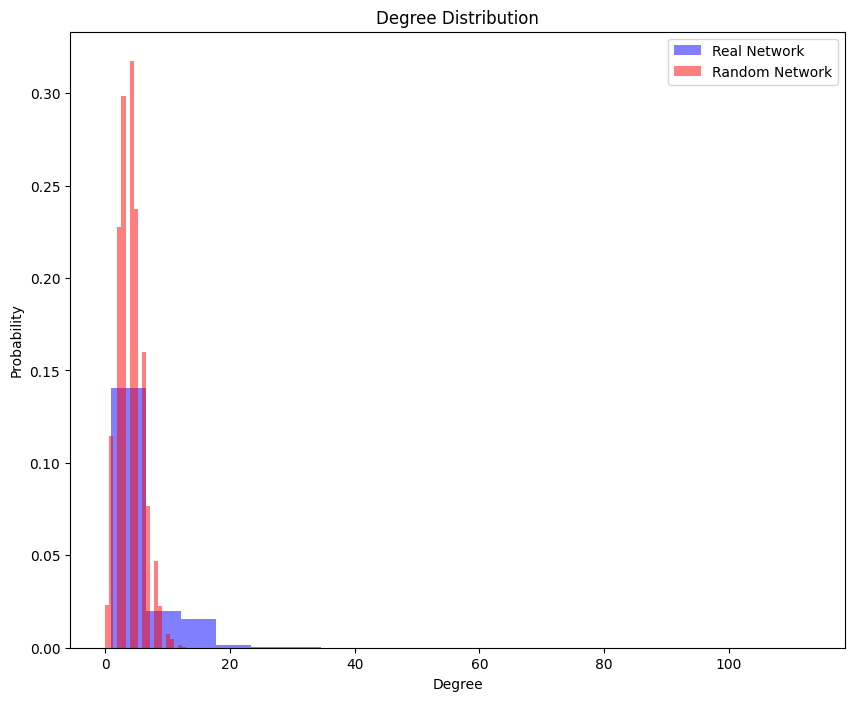

In [69]:
degree_sequence_G = [d for n, d in G.degree()]
degree_sequence_rn = [d for n, d in rn.degree()]

plt.figure(figsize=(10, 8))
plt.hist(degree_sequence_G, bins=20, alpha=0.5, color='b', density=True, label='Real Network')
plt.hist(degree_sequence_rn, bins=20, alpha=0.5, color='r', density=True, label='Random Network')

plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Degree Distribution')
plt.legend(loc='upper right')
plt.show()

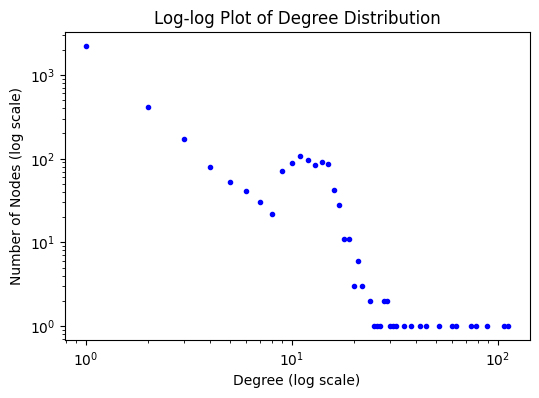

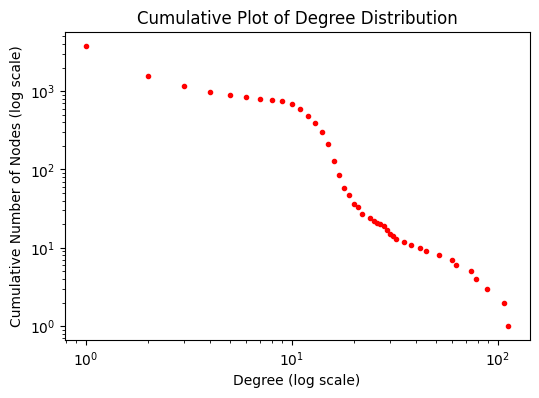

In [70]:
degree_counts_G = Counter(degree_sequence_G)

sorted_degrees = sorted(degree_counts_G.keys())
cumulative_counts = [sum(degree_counts_G[d] for d in sorted_degrees if d >= degree) for degree in sorted_degrees]

# log-log plot
plt.figure(figsize=(6, 4))
plt.loglog(sorted_degrees, [degree_counts_G[d] for d in sorted_degrees], 'bo', markersize=3)
plt.xlabel('Degree (log scale)')
plt.ylabel('Number of Nodes (log scale)')
plt.title('Log-log Plot of Degree Distribution')
plt.grid(True, which="both", ls='')
plt.show()

# cumulative plot
plt.figure(figsize=(6, 4))
plt.loglog(sorted_degrees, cumulative_counts, 'ro', markersize=3)
plt.xlabel('Degree (log scale)')
plt.ylabel('Cumulative Number of Nodes (log scale)')
plt.title('Cumulative Plot of Degree Distribution')
plt.grid(True, which="both", ls="")
plt.show()

In [71]:
# degree centrailty
degree_centrality = nx.degree_centrality(G)
degree_central = max(degree_centrality,key=degree_centrality.get)

# closeness centrailty
closeness_centrality = nx.closeness_centrality(G)
close_central = max(closeness_centrality,key=closeness_centrality.get)

# betweenness centrality
betw_centrality = nx.betweenness_centrality(G)
betw_central = max(betw_centrality,key=betw_centrality.get)

# eigenvector centrality
eigen_centrality = nx.eigenvector_centrality(G)
eigen_central = max(eigen_centrality,key=eigen_centrality.get)

print("Most central nodes according to the following definitions:",
      "\t\n\nDegree:", degree_central,
      "\t\n\nCloseness", close_central,
      "\t\n\nBetweenness", betw_central,
      "\t\n\nEigenvector", eigen_central)

Most central nodes according to the following definitions: 	

Degree: Microsoft 	

Closeness Microsoft 	

Betweenness Microsoft 	

Eigenvector Microsoft


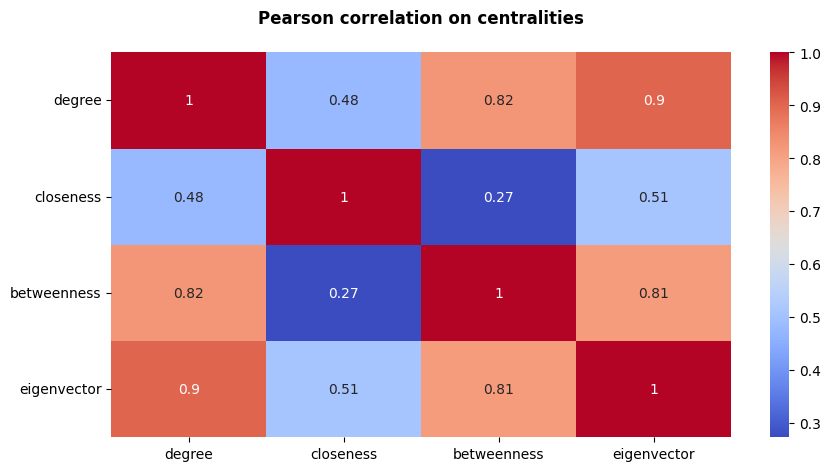

In [72]:
all_centr = [degree_centrality,closeness_centrality,betw_centrality,eigen_centrality]
corrs = [[scipy.stats.pearsonr(list(c1.values()), list(c2.values()))[0] for c1 in all_centr] for c2 in all_centr]
centralities = ['degree', 'closeness','betweenness','eigenvector']
plt.figure(figsize = (10,5))
sns.heatmap(pd.DataFrame(corrs),annot = True,cmap = 'coolwarm')
plt.xticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.yticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.title('Pearson correlation on centralities\n', weight = 'bold')
plt.show()

In [73]:
sort_degree_centrality = dict(sorted(degree_centrality.items(),key=lambda item:item[1],reverse=True))
top_degree = list(sort_degree_centrality.keys())[:5]

sort_close_centrality = dict(sorted(closeness_centrality.items(),key=lambda item:item[1],reverse=True))
top_close = list(sort_close_centrality.keys())[:5]

sort_betw_centrality = dict(sorted(betw_centrality.items(),key=lambda item:item[1],reverse=True))
top_betw = list(sort_betw_centrality.keys())[:5]

sort_eigen_centrality = dict(sorted(eigen_centrality.items(),key=lambda item:item[1],reverse=True))
top_eigen = list(sort_eigen_centrality.keys())[:5]

print(
    "Top 5 nodes according to:\t\nDegree centrality:", top_degree,"\nCloseness:", top_close, "\nBetweness:", top_betw,
    "\nEigenvector:", top_eigen
)

Top 5 nodes according to:	
Degree centrality: ['Microsoft', 'Google', 'IBM', 'Facebook', 'Hewlett-Packard'] 
Closeness: ['Microsoft', 'Google', 'IBM', 'GEICO', 'Facebook'] 
Betweness: ['Microsoft', 'Google', 'IBM', 'Facebook', 'Hewlett-Packard'] 
Eigenvector: ['Microsoft', 'Google', 'IBM', 'Facebook', 'Hewlett-Packard']


In [74]:
if nx.is_connected(G) == True:
  print('The graph is connected')
else:
  print('The graph is not connected')
num_connected_components = nx.number_connected_components(G)
print(f'Number of connetced components in the network: {num_connected_components}')

The graph is not connected
Number of connetced components in the network: 9


In [75]:
# largest connected component
len_components = [len(c) for c in nx.connected_components(G)]
components = [c for c in nx.connected_components(G)]

lcc = G.subgraph(components[0])
print(lcc.number_of_nodes())
print(lcc.number_of_edges())

avg_shrt_path_len_lcc = nx.average_shortest_path_length(lcc)
print(avg_shrt_path_len_lcc)

# diam_lcc = nx.diameter(lcc)
# print(diam_lcc)

3658
7504
4.7280358242534035


In [76]:
# bridges
print(nx.has_bridges(G))
bridges = len(list(nx.bridges(G,root=None)))
print(bridges)
perc_bridge = bridges/G.number_of_edges()
print(perc_bridge)

True
2211
0.29092105263157897


In [77]:
# assortativity
assortativity = nx.degree_assortativity_coefficient(G)
print(assortativity)

-9.310095756061908e-05


In [78]:
gcc = nx.transitivity(G)
avg_lcc = nx.average_clustering(G)

print("Global clustering coefficient:", gcc,"\nAverage local clustering coefficient:", avg_lcc)

Global clustering coefficient: 0.006922402271967925 
Average local clustering coefficient: 0.004911535277319694


In [79]:
# community detection greedy

from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import modularity

greedy_communities = list(greedy_modularity_communities(G))
greedy_modularity_value = modularity(G, greedy_communities)
print(f"Network Modularity (Greedy algorithm): {greedy_modularity_value:.3f}")
greedy_num_partitions = len(greedy_communities)
greedy_partition_sizes = [len(community) for community in greedy_communities]
greedy_partition_sizes.sort(reverse=True)

print(f"Number of partitions (communities) obtained by Greedy algorithm: {greedy_num_partitions}")
print(f"Size of each partition: {greedy_partition_sizes}")


Network Modularity (Greedy algorithm): 0.534
Number of partitions (communities) obtained by Greedy algorithm: 42
Size of each partition: [509, 468, 231, 155, 147, 142, 140, 133, 131, 128, 126, 111, 110, 97, 94, 94, 78, 77, 69, 69, 60, 56, 55, 54, 51, 50, 46, 42, 40, 39, 26, 16, 16, 14, 13, 13, 13, 11, 11, 10, 10, 7]


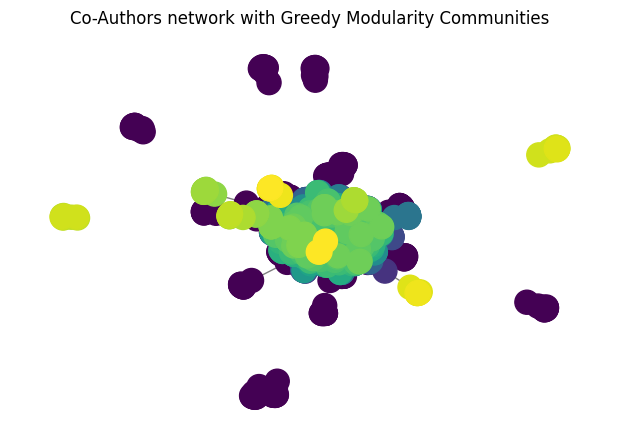

In [80]:
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42)
colors = [i for i, community in enumerate(greedy_communities) for _ in community]
nx.draw(G, pos, with_labels=False, cmap=plt.cm.viridis, node_color=colors, font_size=8, font_color="black", font_weight="bold", edge_color='gray')
plt.title('Co-Authors network with Greedy Modularity Communities')
plt.show()

In [81]:
# Louvain algorithm

import community.community_louvain
partition = community.community_louvain.best_partition(G)

modularity_value = community.community_louvain.modularity(partition, G)
print(f"Network Modularity: {modularity_value:.3f}")
num_partitions = max(partition.values()) + 1
print(f"Number of communities obtained by Louvain algorithm: {num_partitions}")


Network Modularity: 0.535
Number of communities obtained by Louvain algorithm: 39


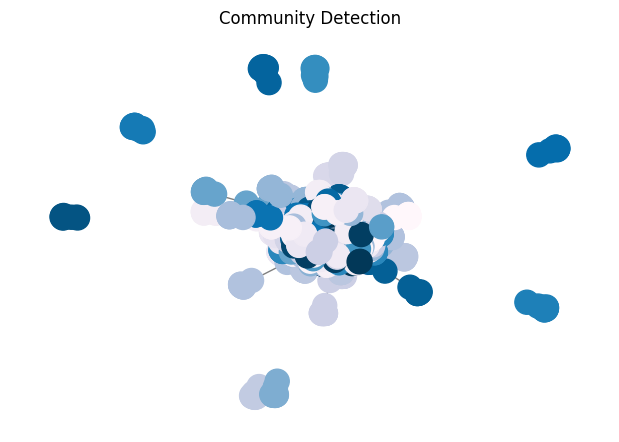

In [82]:

plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed = 42)
node_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_color=node_colors, cmap=plt.cm.PuBu, font_size=8, font_color="black", font_weight="bold", edge_color='gray')
plt.title('Community Detection')
plt.show()

### ML

In [83]:
positive_datapoints = list(G.edges())
positive_datapoints = [(u,v) for u,v in positive_datapoints]
len(positive_datapoints)

7600

In [84]:
negative_datapoints = []
nodes_set = list(G.nodes())
count = 0
while count < len(positive_datapoints):
    u, v = np.random.choice(nodes_set, size=2, replace=True)
    if (not G.has_edge(u, v) and not G.has_edge(v, u)):
        negative_datapoints.append((u, v))
        count += 1

In [85]:
dataset_link_prediction =  pd.DataFrame()
datapoints =  positive_datapoints + negative_datapoints
datapoints[:10]

[('Big Data & Analytics For Financial Services', 'Process Excellence Network'),
 ('Big Data & Analytics For Financial Services', 'Amazon Web Services'),
 ('Big Data & Analytics For Financial Services', 'Intel'),
 ('Big Data & Analytics For Financial Services', 'Splunk'),
 ('Big Data & Analytics For Financial Services', 'Smarsh'),
 ('Big Data & Analytics For Financial Services', 'EY'),
 ('Big Data & Analytics For Financial Services', 'OpenText'),
 ('Big Data & Analytics For Financial Services', 'Corvil'),
 ('Big Data & Analytics For Financial Services', 'Angoss'),
 ('Intel', 'Abengoa')]

In [86]:
dataset_link_prediction['jaccard'] = [j for _,_, j in nx.jaccard_coefficient(G, datapoints)]
dataset_link_prediction['rai'] = [j for _,_, j in nx.resource_allocation_index(G, datapoints)]
dataset_link_prediction['aai'] = [sum(1 / log(G.degree(w)) for w in nx.common_neighbors(G, u, v) if G.degree(w) != 0 and G.degree(w) != 0) if any(G.degree(w) != 0 for w in nx.common_neighbors(G, u, v)) else 0 for u, v in datapoints]
dataset_link_prediction['pref'] = [j for _,_, j in nx.preferential_attachment(G, datapoints)]
dataset_link_prediction['label'] = [1 for _ in range(len(positive_datapoints))] + [0 for _ in range(len(negative_datapoints))]
dataset_link_prediction['home'] = [u for u, _ in datapoints]
dataset_link_prediction['customer'] = [v for _, v in datapoints]
dataset_link_prediction.sample(8)

,jaccard,rai,aai,pref,label,home,customer
2378,0.0,0.0,0.0,75,1,Cypress Semiconductor,Marconi
7769,0.0,0.0,0.0,10,0,Goodwill Industries,UFC
12454,0.0,0.0,0.0,6,0,Trulia,Apparel Group
865,0.0,0.0,0.0,608,1,Virgin America,Samsung
4662,0.0,0.0,0.0,210,1,NextGen Software,Zix
7469,0.0,0.0,0.0,10,1,RealtyTrac,Weichert
14589,0.0,0.0,0.0,3,0,AAR Mobility Systems,Defense Logistics Agency
14424,0.0,0.0,0.0,8,0,State bank of India,Aconex


In [87]:
X = dataset_link_prediction[['jaccard', 'rai', 'aai', 'pref', 'home', 'customer']]
y = dataset_link_prediction['label']

X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_.shape, y_train.shape

X_train = X_train_.drop(columns = ['home', 'customer'])
X_test = X_test_.drop(columns = ['home', 'customer'])

X_train.shape, X_test.shape

((11400, 4), (3800, 4))

In [88]:
column_preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), ['jaccard', 'rai', 'aai', 'pref'])],
    remainder='passthrough'
)

link_predictor = Pipeline([
    ('preprocessing', column_preprocessor),
    ('classifier', LogisticRegression(penalty=None))])

link_predictor.fit(X_train, y_train)
accuracy = link_predictor.score(X_test, y_test)
print(f"Accuracy on the testing set: {accuracy:.2%}")

Accuracy on the testing set: 74.87%


In [89]:
y_predicted = link_predictor.predict(X_test)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.68      0.93      0.79      1910
           1       0.88      0.57      0.69      1890

    accuracy                           0.75      3800
   macro avg       0.78      0.75      0.74      3800
weighted avg       0.78      0.75      0.74      3800



In [90]:
print(link_predictor['classifier'].coef_)

coefficients = link_predictor['classifier'].coef_

probabilities = X_test_[['jaccard', 'rai', 'aai', 'pref']].dot(coefficients.T.reshape(-1, 1))

threshold = 0.5
connected_indices = probabilities > threshold
connected_indices = connected_indices.values
connected_pairs = X_test_.loc[connected_indices[:, 0], ['home', 'customer']]
connected_pairs = connected_pairs.drop_duplicates()
print(connected_pairs.head(10))

[[-1.36184222  7.589183   -7.5266796  51.68974166]]
                   home          customer
3165             InMobi              IDEO
3691           Citibank           Xiotech
3297           Symantec            Vitria
10409              Exel         Medtronic
7934                IHS         Phone.com
3488             Flickr              Cyan
7050              Cvent      PriceGrabber
1310            MariaDB  VERKKOKAUPPA.COM
8724   Novatel Wireless           Egencia
8192         State Farm          Maverick


In [91]:
connected_pairs.sample(10)

,home,customer
4767,Chanel,Zebra Technologies
4339,Intergraph,InvenSense
6005,MapR Technologies,Wyeth
1748,Apollo Group,Latham & Watkins
9806,Zend,MetLife
11859,Saudi Basic Industries,Kellstrom Industries
2478,Amazon,BroadVision
4685,Chesapeake Energy,Kiehl
9820,IO,Appoxee
11592,Cloud Connect,Nuix


# Collabs

In [203]:
G = nx.Graph()
G = nx.from_pandas_edgelist(collabs, 'home_name', 'link_name')
print(G)

Graph with 43065 nodes and 108831 edges


In [204]:
unique_home_companies = collabs['home_name'].unique()
random_selected_home_companies = np.random.choice(unique_home_companies, size=1000, replace=False)
sampled_partnership = collabs[(collabs['home_name'].isin(random_selected_home_companies)) & (collabs['link_name'].isin(random_selected_home_companies))
                                  ]
partnership_count = sampled_partnership.groupby('home_name').size()
selected_home_companies = partnership_count[partnership_count > 1].index
sampled_partnership = sampled_partnership[sampled_partnership['home_name'].isin(selected_home_companies)]

sampled_partnership

,home_name,link_name,type
3089,BCS,Microsoft,partnership
3090,BCS,Oracle,partnership
3968,Datawatch,Teradata,partnership
3969,Datawatch,Oracle,partnership
3971,Datawatch,Microsoft,partnership
...,...,...,...
277951,Twin Technologies,Ping Identity,partnership
277965,Twin Technologies,Warner Music Group,partnership
277970,Twin Technologies,AdsWizz,partnership
278114,Microsoft,Fiserv,partnership


In [205]:
G = nx.Graph()
G = nx.from_pandas_edgelist(sampled_partnership, 'home_name', 'link_name')
print(G)

Graph with 323 nodes and 716 edges


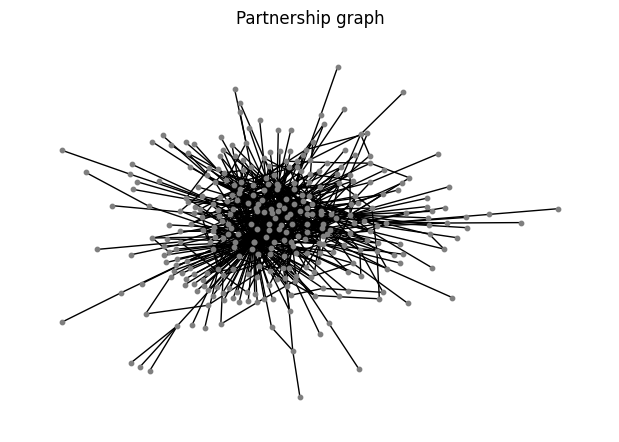

In [206]:
plt.figure(figsize=(6, 4))

nx.draw(G, with_labels=False, node_size=10, node_color="tab:grey", pos=nx.spring_layout(G))
plt.title("Partnership graph")
plt.show()

### EDA

In [207]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
density = nx.density(G)
print(f"\nThe density of the network: {density:.4f}")

Number of nodes: 323
Number of edges: 716

The density of the network: 0.0138


In [208]:
degrees = list(dict(G.degree()).values())

avg_degree = np.mean(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)
std_dev_degree = np.std(degrees)
median_degree = np.median(degrees)

print('Avg.degree:', avg_degree, "\n\nMin degree:", min_degree,
      "\n\nMax degree:", max_degree, "\n\nStandard Deviation:", std_dev_degree,
      "\n\nMedian:", median_degree)

Avg.degree: 4.43343653250774 

Min degree: 1 

Max degree: 146 

Standard Deviation: 10.002680582743766 

Median: 2.0


In [209]:
num_connected_components = nx.number_connected_components(G)
print(f'Number of connetced components in the network: {num_connected_components}')

Number of connetced components in the network: 1


In [210]:
rn = nx.fast_gnp_random_graph(G.order(),density)

random_nodes = rn.order()
random_edges = rn.size()
print("Random nodes:", random_nodes,"\nRandom edges:", random_edges)

num_connected_components = nx.number_connected_components(rn)
print(f'Number of connetced components in the network: {num_connected_components}')

degrees = list(dict(rn.degree()).values())

avg_degree = np.mean(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)
std_dev_degree = np.std(degrees)
median_degree = np.median(degrees)

print('Avg.degree:', avg_degree, "\n\nMin degree:", min_degree,
      "\n\nMax degree:", max_degree, "\n\nStandard Deviation:", std_dev_degree,
      "\n\nMedian:", median_degree)

Random nodes: 323 
Random edges: 706
Number of connetced components in the network: 10
Avg.degree: 4.371517027863777 

Min degree: 0 

Max degree: 10 

Standard Deviation: 1.9588790917638792 

Median: 4.0


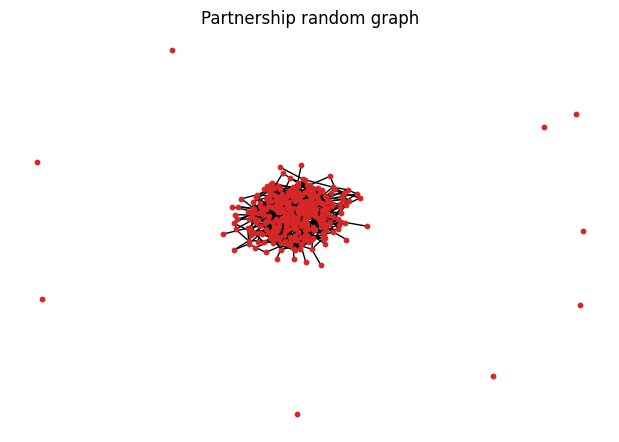

In [211]:
plt.figure(figsize=(6, 4))

nx.draw(rn, with_labels=False, node_size=10, node_color="tab:red", pos=nx.spring_layout(rn))
plt.title("Partnership random graph")
plt.show()

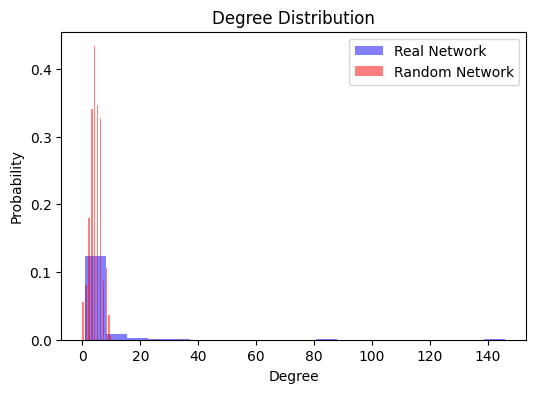

In [212]:
degree_sequence_G = [d for n, d in G.degree()]
degree_sequence_rn = [d for n, d in rn.degree()]

plt.figure(figsize=(6, 4))
plt.hist(degree_sequence_G, bins=20, alpha=0.5, color='b', density=True, label='Real Network')
plt.hist(degree_sequence_rn, bins=20, alpha=0.5, color='r', density=True, label='Random Network')

plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Degree Distribution')
plt.legend(loc='upper right')
plt.show()

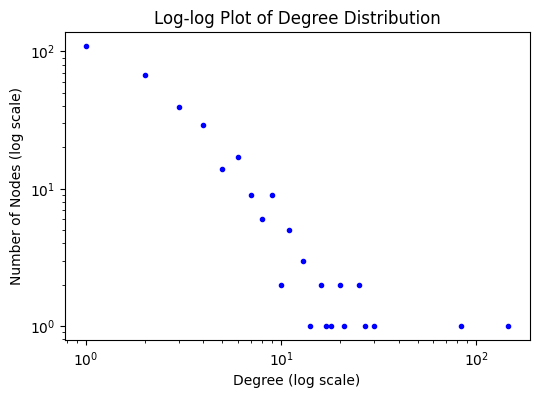

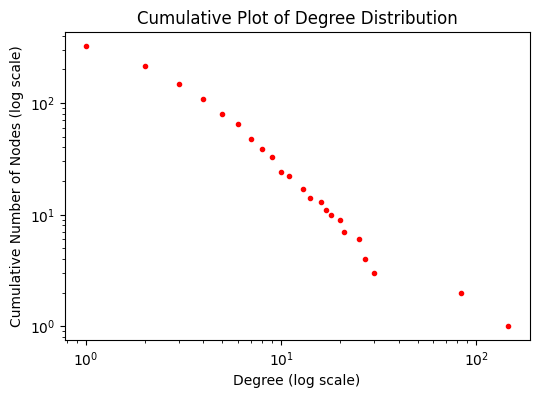

In [213]:
degree_counts_G = Counter(degree_sequence_G)

sorted_degrees = sorted(degree_counts_G.keys())
cumulative_counts = [sum(degree_counts_G[d] for d in sorted_degrees if d >= degree) for degree in sorted_degrees]

# log-log plot
plt.figure(figsize=(6, 4))
plt.loglog(sorted_degrees, [degree_counts_G[d] for d in sorted_degrees], 'bo', markersize=3)
plt.xlabel('Degree (log scale)')
plt.ylabel('Number of Nodes (log scale)')
plt.title('Log-log Plot of Degree Distribution')
plt.grid(True, which="both", ls='')
plt.show()

# cumulative plot
plt.figure(figsize=(6, 4))
plt.loglog(sorted_degrees, cumulative_counts, 'ro', markersize=3)
plt.xlabel('Degree (log scale)')
plt.ylabel('Cumulative Number of Nodes (log scale)')
plt.title('Cumulative Plot of Degree Distribution')
plt.grid(True, which="both", ls="")
plt.show()

In [214]:
# degree centrailty
degree_centrality = nx.degree_centrality(G)
degree_central = max(degree_centrality,key=degree_centrality.get)

# closeness centrailty
closeness_centrality = nx.closeness_centrality(G)
close_central = max(closeness_centrality,key=closeness_centrality.get)

# betweenness centrality
betw_centrality = nx.betweenness_centrality(G)
betw_central = max(betw_centrality,key=betw_centrality.get)

# eigenvector centrality
eigen_centrality = nx.eigenvector_centrality(G)
eigen_central = max(eigen_centrality,key=eigen_centrality.get)

print("Most central nodes according to the following definitions:",
      "\t\n\nDegree:", degree_central,
      "\t\n\nCloseness", close_central,
      "\t\n\nBetweenness", betw_central,
      "\t\n\nEigenvector", eigen_central
      )

Most central nodes according to the following definitions: 	

Degree: Microsoft 	

Closeness Microsoft 	

Betweenness Microsoft 	

Eigenvector Microsoft


In [215]:
sort_degree_centrality = dict(sorted(degree_centrality.items(),key=lambda item:item[1],reverse=True))
top_degree = list(sort_degree_centrality.keys())[:5]

sort_close_centrality = dict(sorted(closeness_centrality.items(),key=lambda item:item[1],reverse=True))
top_close = list(sort_close_centrality.keys())[:5]

sort_betw_centrality = dict(sorted(betw_centrality.items(),key=lambda item:item[1],reverse=True))
top_betw = list(sort_betw_centrality.keys())[:5]

sort_eig_centrality = dict(sorted(eigen_centrality.items(),key=lambda item:item[1],reverse=True))
top_eigen = list(sort_eig_centrality.keys())[:5]

print(
    "Top 10 nodes according to:\t\nDegree centrality:", top_degree,"\nCloseness:", top_close, "\nBetweness:", top_betw, top_eigen)

Top 10 nodes according to:	
Degree centrality: ['Microsoft', 'Oracle', 'T-Mobile', 'Lenovo', 'Teradata'] 
Closeness: ['Microsoft', 'Oracle', 'LG', 'Starbucks', 'Teradata'] 
Betweness: ['Microsoft', 'Oracle', 'Teradata', 'Lenovo', 'T-Mobile'] ['Microsoft', 'Oracle', 'LG', 'T-Mobile', 'Lenovo']


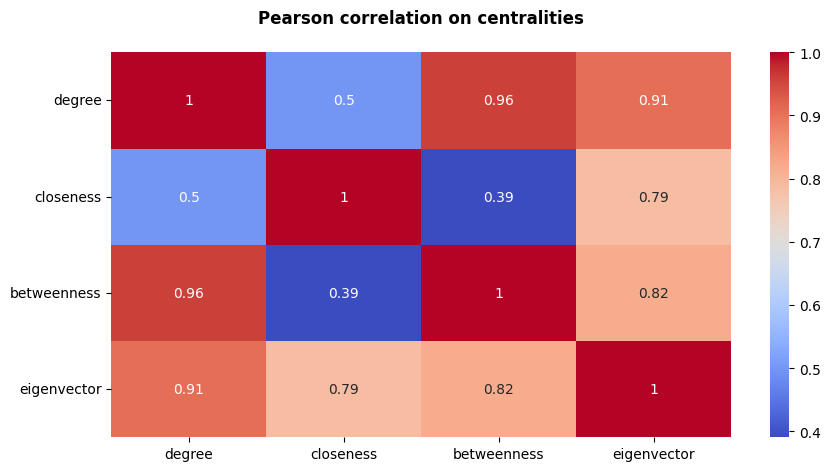

In [216]:
all_centr = [degree_centrality,closeness_centrality,betw_centrality, eigen_centrality]
corrs = [[scipy.stats.pearsonr(list(c1.values()), list(c2.values()))[0] for c1 in all_centr] for c2 in all_centr]
centralities = ['degree', 'closeness','betweenness', 'eigenvector']
plt.figure(figsize = (10,5))
sns.heatmap(pd.DataFrame(corrs),annot = True,cmap = 'coolwarm')
plt.xticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.yticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.title('Pearson correlation on centralities\n', weight = 'bold')
plt.show()

In [217]:
if nx.is_connected(G) == True:
  print('The graph is connected')
else:
  print('The graph is not connected')
num_connected_components = nx.number_connected_components(G)
print(f'Number of connetced components in the network: {num_connected_components}')

The graph is connected
Number of connetced components in the network: 1


In [218]:
# largest connected component
len_components = [len(c) for c in nx.connected_components(G)]
components = [c for c in nx.connected_components(G)]

lcc = G.subgraph(components[0])
print(lcc.number_of_nodes())
print(lcc.number_of_edges())

avg_shrt_path_len_lcc = nx.average_shortest_path_length(lcc)
print(avg_shrt_path_len_lcc)

diam_lcc = nx.diameter(lcc)
print(diam_lcc)

323
716
2.98523162125262
7


In [219]:
components_count = defaultdict(int)

for comp in len_components:
  components_count[comp] +=1

components_count

defaultdict(int, {323: 1})

In [220]:
# bridges
print(nx.has_bridges(G))
bridges = len(list(nx.bridges(G,root=None)))
print(bridges)
perc_bridge = bridges/G.number_of_edges()
print(perc_bridge)

True
116
0.16201117318435754


In [221]:
def count_local_and_global_bridges(G):
    local_bridges = 0
    global_bridges = 0

    for edge in G.edges():
        temp_G = G.copy()
        temp_G.remove_edge(*edge)


        if nx.is_connected(temp_G):

            u, v = edge
            if not nx.has_path(temp_G, u, v):
                local_bridges += 1
        else:
            global_bridges += 1

    return local_bridges, global_bridges

local_bridges, global_bridges = count_local_and_global_bridges(G)
print("Local Bridges:", local_bridges)
print("Global Bridges:", global_bridges)

Local Bridges: 0
Global Bridges: 116


In [222]:
# assortativity
assortativity = nx.degree_assortativity_coefficient(G)
print(assortativity)

-0.22278941794551219


In [223]:
gcc = nx.transitivity(G)
avg_lcc = nx.average_clustering(G)

print("Global clustering coefficient:", gcc,"\nAverage local clustering coefficient:", avg_lcc)

Global clustering coefficient: 0.05720577966374819 
Average local clustering coefficient: 0.17402784863006737


In [224]:
# community detection greedy

from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import modularity

greedy_communities = list(greedy_modularity_communities(G))
greedy_modularity_value = modularity(G, greedy_communities)
print(f"Network Modularity (Greedy algorithm): {greedy_modularity_value:.3f}")
greedy_num_partitions = len(greedy_communities)
greedy_partition_sizes = [len(community) for community in greedy_communities]
greedy_partition_sizes.sort(reverse=True)

print(f"Number of partitions (communities) obtained by Greedy algorithm: {greedy_num_partitions}")
print(f"Size of each partition: {greedy_partition_sizes}")

Network Modularity (Greedy algorithm): 0.431
Number of partitions (communities) obtained by Greedy algorithm: 13
Size of each partition: [52, 52, 52, 44, 31, 31, 16, 13, 11, 8, 6, 4, 3]


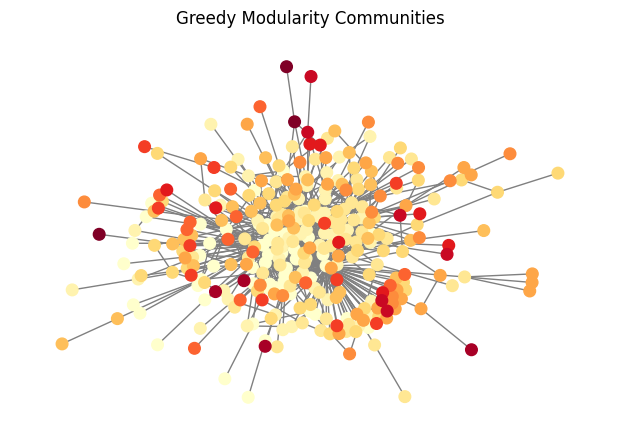

In [225]:
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42)
colors = [i for i, community in enumerate(greedy_communities) for _ in community]
nx.draw(G, pos, with_labels=False, node_size=70, cmap=plt.cm.YlOrRd, node_color=colors, edge_color='gray')
plt.title('Greedy Modularity Communities')
plt.show()

In [226]:
# Louvain algorithm

import community.community_louvain
partition = community.community_louvain.best_partition(G)

modularity_value = community.community_louvain.modularity(partition, G)
print(f"Network Modularity: {modularity_value:.3f}")
num_partitions = max(partition.values()) + 1
print(f"Number of communities obtained by Louvain algorithm: {num_partitions}")

Network Modularity: 0.431
Number of communities obtained by Louvain algorithm: 12


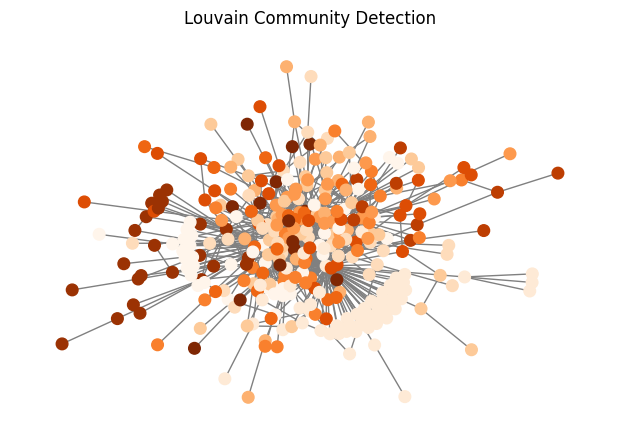

In [227]:
plt.figure(figsize=(6,4))
pos = nx.spring_layout(G, seed = 42)
node_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, with_labels=False, node_size=70, node_color=node_colors, cmap=plt.cm.Oranges, edge_color='gray')
plt.title('Louvain Community Detection')
plt.show()

### ML

In [228]:
positive_datapoints = list(G.edges())
positive_datapoints = [(u,v) for u,v in positive_datapoints]
len(positive_datapoints)

negative_datapoints = []
nodes_set = list(G.nodes())
count = 0
while count < len(positive_datapoints):
    u, v = np.random.choice(nodes_set, size=2, replace=True)
    if (not G.has_edge(u, v) and not G.has_edge(v, u)):
        negative_datapoints.append((u, v))
        count += 1


dataset_link_prediction =  pd.DataFrame()
datapoints =  positive_datapoints + negative_datapoints
datapoints[:10]

[('BCS', 'Microsoft'),
 ('BCS', 'Oracle'),
 ('Microsoft', 'Datawatch'),
 ('Microsoft', 'Fujitsu'),
 ('Microsoft', 'GFT IT Consulting'),
 ('Microsoft', 'HCL'),
 ('Microsoft', 'SUSE'),
 ('Microsoft', 'Teradata'),
 ('Microsoft', 'Tieto'),
 ('Microsoft', 'Nimble Storage')]

In [229]:
dataset_link_prediction['jaccard'] = [j for _,_, j in nx.jaccard_coefficient(G, datapoints)]
dataset_link_prediction['rai'] = [j for _,_, j in nx.resource_allocation_index(G, datapoints)]
dataset_link_prediction['aai'] = [sum(1 / log(G.degree(w)) for w in nx.common_neighbors(G, u, v) if G.degree(w) != 0 and G.degree(w) != 0) if any(G.degree(w) != 0 for w in nx.common_neighbors(G, u, v)) else 0 for u, v in datapoints]
dataset_link_prediction['pref'] = [j for _,_, j in nx.preferential_attachment(G, datapoints)]
dataset_link_prediction['label'] = [1 for _ in range(len(positive_datapoints))] + [0 for _ in range(len(negative_datapoints))]
dataset_link_prediction['home'] = [u for u, _ in datapoints]
dataset_link_prediction['customer'] = [v for _, v in datapoints]
dataset_link_prediction.sample(8)

,jaccard,rai,aai,pref,label,home,customer
142,0.000000,0.000000,0.000000,146,1,Microsoft,Stop & Shop
38,0.026667,0.288159,1.472989,1168,1,Microsoft,Synopsys
868,0.000000,0.000000,0.000000,25,0,Teradata,Barneys
1142,0.000000,0.000000,0.000000,6,0,Financial Engines,deCarta
1040,0.000000,0.000000,0.000000,13,0,Nielsen,"University of California, Irvine"
96,0.000000,0.000000,0.000000,146,1,Microsoft,CBS Outdoor
966,0.111111,0.006849,0.200658,25,0,Webtrends,Burger King
886,0.000000,0.000000,0.000000,4,0,Square Enix,Accela


In [230]:
X = dataset_link_prediction[['jaccard', 'rai', 'aai', 'pref', 'home', 'customer']]
y = dataset_link_prediction['label']

X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_.shape, y_train.shape

X_train = X_train_.drop(columns = ['home', 'customer'])
X_test = X_test_.drop(columns = ['home', 'customer'])

X_train.shape, X_test.shape

((1074, 4), (358, 4))

In [231]:
column_preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), ['jaccard', 'rai', 'aai', 'pref'])],
    remainder='passthrough'
)

link_predictor = Pipeline([
    ('preprocessing', column_preprocessor),
    ('classifier', LogisticRegression(penalty=None))])

link_predictor.fit(X_train, y_train)
accuracy = link_predictor.score(X_test, y_test)
print(f"Accuracy on the testing set: {accuracy:.2%}")

Accuracy on the testing set: 75.98%


In [232]:
y_predicted = link_predictor.predict(X_test)
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.70      0.95      0.80       184
           1       0.91      0.56      0.70       174

    accuracy                           0.76       358
   macro avg       0.80      0.75      0.75       358
weighted avg       0.80      0.76      0.75       358



In [233]:
print(link_predictor['classifier'].coef_)

coefficients = link_predictor['classifier'].coef_

probabilities = X_test_[['jaccard', 'rai', 'aai', 'pref']].dot(coefficients.T.reshape(-1, 1))

threshold = 0.5
connected_indices = probabilities > threshold
connected_indices = connected_indices.values
connected_pairs = X_test_.loc[connected_indices[:, 0], ['home', 'customer']]
connected_pairs = connected_pairs.drop_duplicates()
print(connected_pairs.head(10))

[[ -8.1867285  -49.75982111  75.31409666 237.77010385]]
              home              customer
123      Microsoft               Daimler
1192       Fujitsu               Netlink
462             LG            PhotoMedex
351        SunGard             Hydro One
1057          IMCD          Tesla Motors
665   Global Green         Martin Agency
1324         WebMD   Hendrick Automotive
527       T-Mobile                 Velti
70       Microsoft  Genesys Conferencing
554            ITT           Design News


In [234]:
connected_pairs.sample(10)

,home,customer
737,TIBCO Software,First Data Corporation
941,Appnovation Technologies,Jeppesen
78,Microsoft,WeddingWire
741,DIRECTV,Aerospace Industries Association
432,Ping Identity,Skyhigh Networks
938,BAE Systems,IO
1066,Keppel,CTS
1006,Replacement Parts,Qualys
1192,Fujitsu,Netlink
259,TIBCO Software,Persistent Systems


### ML

In [235]:
# !pip install node2vec
from node2vec import Node2Vec

#p Parameter: Controls the likelihood of returning to the previous node in a random walk.
## A higher value biases the walk towards revisiting recent locations, promoting the exploitation of local structures.
# q Parameter: Governs the likelihood of moving away from the previous node.
## A lower value encourages exploration, allowing the walk to move towards nodes further away.

In [236]:
node2vec = Node2Vec(G,dimensions=64,walk_length=30,num_walks=500,p=2,q=1,workers=2)
model = node2vec.fit(window=6,min_count=1,batch_words=3)

def rec(collab):
  companies = []

  for company in model.wv.most_similar(str(collab))[:5]:
    companies.append(company)

  print(companies)

Computing transition probabilities:   0%|          | 0/323 [00:00<?, ?it/s]

In [237]:
rec("Siemens")
rec("Microsoft")
rec("Boeing")

KeyError: "Key 'Siemens' not present in vocabulary"

In [ ]:
bottom_degree = list(sort_degree_centrality.keys())[-5:]

In [ ]:
for node in bottom_degree:
  rec(node)

In [ ]:
node2vec = Node2Vec(G,dimensions=64,walk_length=30,num_walks=500,p=1,q=2,workers=2)
model = node2vec.fit(window=6,min_count=1,batch_words=3)

def rec(collab):
  companies = []

  for company in model.wv.most_similar(str(collab))[:5]:
    companies.append(company)

  print(companies)

rec("Siemens")
rec("Microsoft")
rec("Boeing")

bottom_degree = list(sort_degree_centrality.keys())[-5:]
for node in bottom_degree:
  rec(node)